# 0. Kütüphanelerin Eklenmesi

#### 🔹 Temel Python Kütüphaneleri
- `os`: Dosya ve dizin işlemleri
- `math`: Matematiksel işlemler
- `random`: Rastgele sayı üretimi

#### 🔹 Veri İşleme Kütüphaneleri
- `numpy`: Sayısal işlemler ve array manipülasyonu
- `sklearn`: Veri bölme ve metrik hesaplama
- `seaborn`: İstatistiksel veri görselleştirme

#### 🔹 Görüntü İşleme
- `PIL`: Python Görüntü Kütüphanesi

#### 🔹 Deep Learning
- `tensorflow`: Derin öğrenme modeli oluşturma
- `keras`: Yüksek seviyeli sinir ağı API'si
- `keras_tuner`: Hiperparametre optimizasyonu

#### 🔹 Görselleştirme
- `matplotlib`: Veri görselleştirme ve grafik oluşturma

In [1]:
# Temel Python kütüphaneleri
import os
import math
import random

# Veri işleme ve bilimsel hesaplama
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

# Görüntü işleme
from PIL import Image

# Dosya işlemleri
import shutil

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Activation,
    BatchNormalization
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

# Görselleştirme
import matplotlib.pyplot as plt

# 1. Global Değişkenlerin Tanımlanması

#### 🔹 Görüntü ve Veri İşleme Parametreleri
- `IMAGE_SIZE`: 224 - Görüntülerin yeniden boyutlandırılacağı piksel boyutu
- `BATCH_SIZE`: 32 - Her bir eğitim adımında işlenecek görüntü sayısı
- `NUM_CLASS`: 13 - Sınıflandırılacak Simpson karakteri sayısı

#### 🔹 Eğitim Parametreleri
- `EPOCHS`: 50 - Modelin eğitim döngüsü sayısı
- `TUNER_ITERATIONS`: 2 - Hiperparametre optimizasyonu için kaç tane 30 deneme yapılacağının sayısı

#### 🔹 Performans Optimizasyonu
- `AUTOTUNE`: TensorFlow'un otomatik performans optimizasyonu için kullanılan parametre

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASS = 13

EPOCHS = 50
TUNER_ITERATIONS = 2

AUTOTUNE = tf.data.AUTOTUNE

# 2. Veri Seti Analizi

Simpson karakterlerinin veri setindeki dağılımı analiz edilip pasta grafiğinde gösteriliyor. 

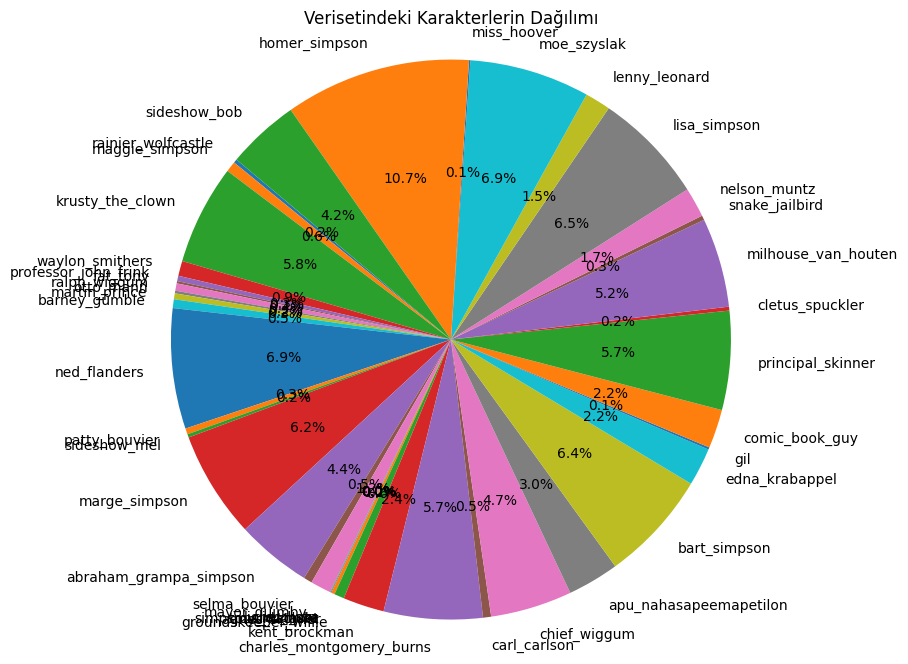

In [3]:
input_dir = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset"

character_counts = {}

for character_folder in os.listdir(input_dir):
    character_folder_path = os.path.join(input_dir, character_folder)

    if os.path.isdir(character_folder_path):
        num_files = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])

        character_counts[character_folder] = num_files

plt.figure(figsize=(10, 8))
plt.pie(character_counts.values(), labels=character_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Verisetindeki Karakterlerin Dağılımı')
plt.axis('equal')
plt.show()

In [4]:
sorted_counts = sorted(character_counts.items(), key=lambda x: x[1])
print("Hangi Karakterden ne kadar görsel var: (Azdan Çoğa Doğru)")
for character, count in sorted_counts:
    print(f"{character}: {count} görsel")

Hangi Karakterden ne kadar görsel var: (Azdan Çoğa Doğru)
simpsons_dataset: 0 görsel
lionel_hutz: 3 görsel
disco_stu: 8 görsel
troy_mcclure: 8 görsel
miss_hoover: 17 görsel
fat_tony: 27 görsel
gil: 27 görsel
otto_mann: 32 görsel
sideshow_mel: 40 görsel
agnes_skinner: 42 görsel
rainier_wolfcastle: 45 görsel
cletus_spuckler: 47 görsel
snake_jailbird: 55 görsel
professor_john_frink: 65 görsel
martin_prince: 71 görsel
patty_bouvier: 72 görsel
ralph_wiggum: 89 görsel
carl_carlson: 98 görsel
selma_bouvier: 103 görsel
barney_gumble: 106 görsel
groundskeeper_willie: 121 görsel
maggie_simpson: 128 görsel
waylon_smithers: 181 görsel
mayor_quimby: 246 görsel
lenny_leonard: 310 görsel
nelson_muntz: 358 görsel
edna_krabappel: 457 görsel
comic_book_guy: 469 görsel
kent_brockman: 498 görsel
apu_nahasapeemapetilon: 623 görsel
sideshow_bob: 877 görsel
abraham_grampa_simpson: 913 görsel
chief_wiggum: 986 görsel
milhouse_van_houten: 1079 görsel
charles_montgomery_burns: 1193 görsel
principal_skinner: 119

# 3. Veri Seti Bölümlenmesi

Her karakter görselleri için %70 Train (Eğitim), %15 Validation (Doğrulama) ve %15 Test olucak şekilde bölümlere ayrılıyor. 

#### Seçilen Karakterler
- Sideshow Bob
- Abraham (Grampa) Simpson
- Chief Wiggum
- Milhouse Van Houten
- Charles Montgomery Burns
- Principal Skinner
- Krusty the Clown
- Marge Simpson
- Bart Simpson
- Lisa Simpson
- Moe Szyslak
- Ned Flanders
- Homer Simpson


In [5]:
allowed_classes = [
    "sideshow_bob", "abraham_grampa_simpson", "chief_wiggum", "milhouse_van_houten",
    "charles_montgomery_burns", "principal_skinner", "krusty_the_clown", "marge_simpson",
    "bart_simpson", "lisa_simpson", "moe_szyslak", "ned_flanders", "homer_simpson"
]

input_dir = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset"
output_dir = "./dataset_filtered"

os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in allowed_classes:
    class_path = os.path.join(input_dir, class_name)
    all_images = sorted(os.listdir(class_path))
    train_files, temp_files = train_test_split(all_images, train_size=0.7, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.15 / (1 - 0.7), random_state=42)

    for subset, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        subset_class_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        for file_name in subset_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(subset_class_dir, file_name)
            shutil.copy(src_file, dst_file)

    print(f"'{class_name}' için işlem işlem tamamlandı.")

'sideshow_bob' için işlem işlem tamamlandı.
'abraham_grampa_simpson' için işlem işlem tamamlandı.
'chief_wiggum' için işlem işlem tamamlandı.
'milhouse_van_houten' için işlem işlem tamamlandı.
'charles_montgomery_burns' için işlem işlem tamamlandı.
'principal_skinner' için işlem işlem tamamlandı.
'krusty_the_clown' için işlem işlem tamamlandı.
'marge_simpson' için işlem işlem tamamlandı.
'bart_simpson' için işlem işlem tamamlandı.
'lisa_simpson' için işlem işlem tamamlandı.
'moe_szyslak' için işlem işlem tamamlandı.
'ned_flanders' için işlem işlem tamamlandı.
'homer_simpson' için işlem işlem tamamlandı.


# 4. Sınıf Ağırlıklarının Hesaplanması

Görsel sayıları eşit olmadığından her karakter için veri setinde ne kadar görseli olduğuna göre ağırlık hesaplanıyor.

In [6]:
def calculate_class_weights(allowed_classes, character_counts):
    class_weights = {}
    max_samples = max(character_counts[class_name] for class_name in allowed_classes)
    
    for idx, class_name in enumerate(allowed_classes):
        weight = max_samples / character_counts[class_name]
        class_weights[idx] = weight
    
    return class_weights

class_weights = calculate_class_weights(allowed_classes, character_counts)

print("\nSınıf Ağırlıkları:")
for idx, class_name in enumerate(allowed_classes):
    print(f"{class_name}: {class_weights[idx]:.2f} (Görsel sayısı: {character_counts[class_name]})")


Sınıf Ağırlıkları:
sideshow_bob: 2.56 (Görsel sayısı: 877)
abraham_grampa_simpson: 2.46 (Görsel sayısı: 913)
chief_wiggum: 2.28 (Görsel sayısı: 986)
milhouse_van_houten: 2.08 (Görsel sayısı: 1079)
charles_montgomery_burns: 1.88 (Görsel sayısı: 1193)
principal_skinner: 1.88 (Görsel sayısı: 1194)
krusty_the_clown: 1.86 (Görsel sayısı: 1206)
marge_simpson: 1.74 (Görsel sayısı: 1291)
bart_simpson: 1.67 (Görsel sayısı: 1342)
lisa_simpson: 1.66 (Görsel sayısı: 1354)
moe_szyslak: 1.55 (Görsel sayısı: 1452)
ned_flanders: 1.54 (Görsel sayısı: 1454)
homer_simpson: 1.00 (Görsel sayısı: 2246)


# 5. Veri Setindeki Karakterlerin Görselleştirilmesi 

Verilen dizindeki her karakterden rastgele bir görsel seçip grid şeklinde görselleştiriliyor.


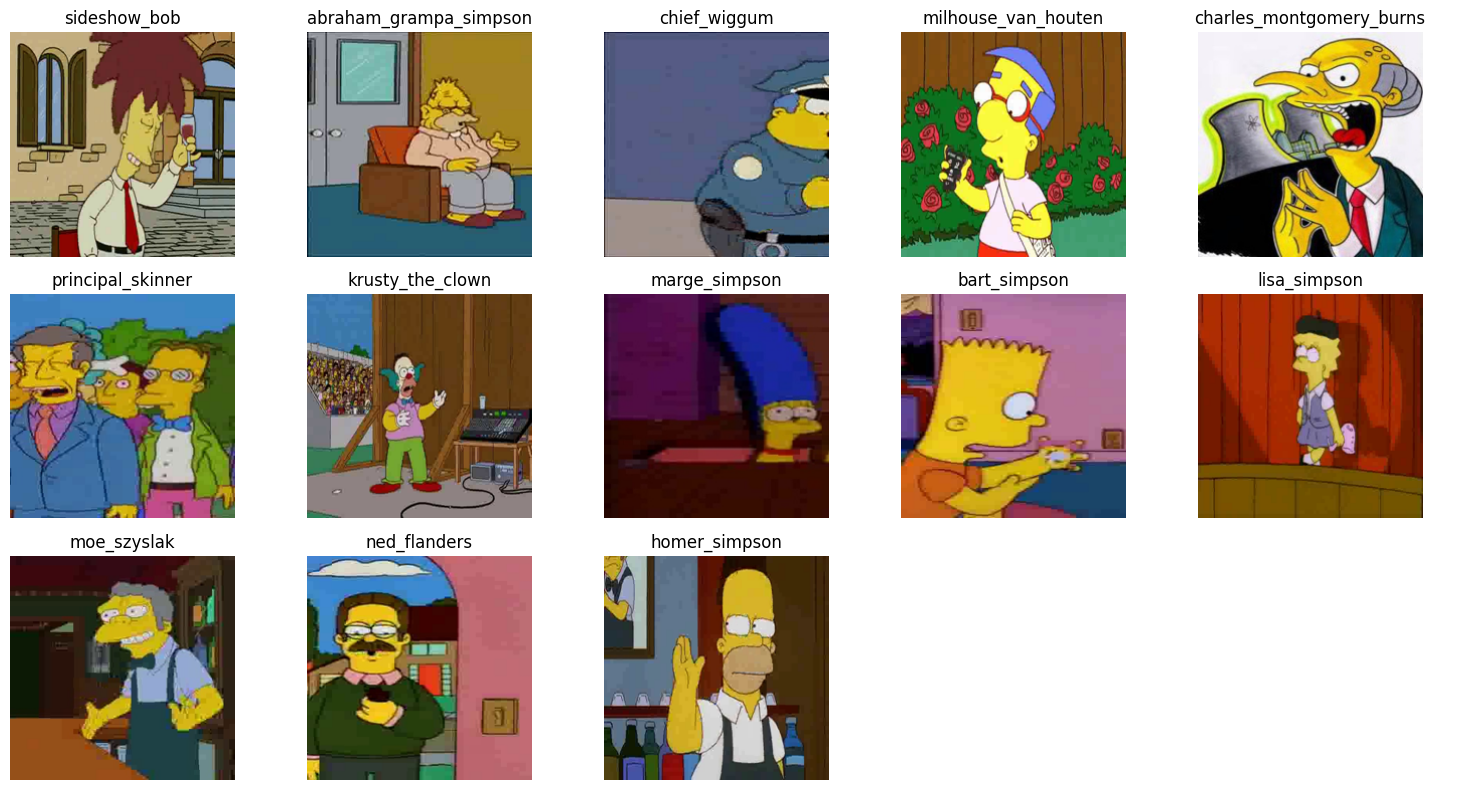

In [7]:
def visualize_random_images(output_dir, allowed_classes, img_size=(224, 224), num_cols=5, figsize=(15, 8)):
    images = []
    for character in allowed_classes:
        class_path = os.path.join(output_dir, character)
        img_files = os.listdir(class_path)
        selected_img = random.choice(img_files)
        img_path = os.path.join(class_path, selected_img)

        img = Image.open(img_path).resize(img_size)
        images.append(img)

    num_rows = math.ceil(len(allowed_classes) / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, (img, label) in enumerate(zip(images, allowed_classes)):
        row, col = divmod(i, num_cols)
        axes[row, col].imshow(img)
        axes[row, col].set_title(label)
        axes[row, col].axis('off')

    for i in range(len(allowed_classes), num_rows * num_cols):
        row, col = divmod(i, num_cols)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_images(test_dir, allowed_classes)

# 6. TensorFlow Datasetlerinin Oluşturulması

#### Parametreler
- `image_size`: (224, 224) - Tüm görüntüler 224x224 boyuta ölçeklendirilirmesini sağlar.
- `batch_size`: 64 - Her iterasyonda işlenecek görüntü sayısını belirler.
- `seed`: 42 - Tekrar üretilebilirlik için sabit seed değerini belirler.
- `label_mode`: "int" - Etiketler tam sayı olarak kodlanmasını sağlar.
- `labels`: "inferred" - Etiketler klasör yapısından otomatik çıkarılmasını sağlar.
- `color_mode`: "rgb" - Görüntüler RGB formatında yüklenmesini sağlar.

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="int",
    labels="inferred",
    color_mode="rgb",
)

class_names = train_dataset.class_names

Found 11605 files belonging to 13 classes.
Found 2489 files belonging to 13 classes.
Found 2493 files belonging to 13 classes.


# 7. Veri Normalizasyonu

Piksel değerlerini 0-255 aralığından 0-1 aralığına normalize ederek, modelin daha etkili öğrenmesini sağlıyoruz.

In [9]:
normalization = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization(x), y))

# 8. Veri Yükleme Performans Optimizasyonu

#### Cache (Önbellekleme)
- `.cache()` metodu ile veriler RAM'de saklanıyor
- İlk epoch'ta veriler okunup bellekte tutuluyor
- Sonraki epoch'larda diskten tekrar okuma yapılmıyor

#### Prefetch (Ön Yükleme)
- `.prefetch()` ile bir sonraki batch önceden hazırlanıyor
- `AUTOTUNE` parametresi ile TensorFlow otomatik optimizasyon yapıyor
- GPU işlem yaparken CPU bir sonraki veriyi hazırlıyor

In [10]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# 9. Model Mimarisi ve Hiperparametre Optimizasyonu

CNN modelimizin mimarisini ve hiperparametre arama uzayını tanımlanıyor. Keras Tuner kullanarak en iyi model parametlerinin bulunması sağlanıyor.

### 🔹 Model Yapısı

#### Giriş Katmanı
- Görüntü boyutu: 224x224x3 (RGB)

#### Evrişim Blokları
- Dinamik sayıda evrişim katmanı (1-6 arası)
- Her blokta:
  - Conv2D (filtre sayısı her katmanda 2 katına çıkar: 32, 64, 128, ...)
  - Batch Normalization
  - ReLU aktivasyonu
  - MaxPooling2D
  - Dropout (0.2)

#### Çıkış Katmanları
- Global Average Pooling
- Dense katman (32-1024 arası nöron)
- Batch Normalization
- Dropout (0.5)
- Softmax çıkış katmanı (13 sınıf)

### 🔹 Optimize Edilen Hiperparametreler

#### Model Yapısı
- `conv_layers`: Evrişim katmanı sayısı (1-6)
- `units`: Yoğun katmandaki nöron sayısı (32-1024)

#### Eğitim Parametreleri
- `learning_rate`: Öğrenme oranı (1e-5 - 1e-3)

In [11]:
def build_model(hp):
    model = tf.keras.models.Sequential()

    # Optimize Edilen Parametreler
    hp_conv_layer_count = hp.Int("conv_layers", min_value=1, max_value=6, step=1)
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
    hp_units = hp.Int("units", min_value=32, max_value=1024, step=32)

    # Giriş Katmanı
    model.add(tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    
    # Evrişim Blokları
    for i in range(hp_conv_layer_count):
        model.add(tf.keras.layers.Conv2D(
            int(32 * (2**i)),
            (3,3),
            padding='same',
            activation=None
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPooling2D((2,2)))
        model.add(tf.keras.layers.Dropout(0.2))

    # Çıkış Katmanları
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(
        hp_units,
        activation="relu"
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(
        NUM_CLASS,
        activation="softmax",
        name="output"
    ))

    # Modelin Derlenmesi
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )
    
    return model

# 10. Hyperband Tuner Konfigürasyonu ve Callback'lerin Tanımlanması

### 🔹 Hyperband Ayarları
- `build_model`: Önceki bölümde tanımlanan model oluşturma fonksiyonu
- `objective`: 'val_loss' (Optimizasyon hedefi)
- `max_epochs`: 10 (Her deneme için maksimum epoch sayısı)
- `hyperband_iterations`: 2 (Hyperband döngü sayısı)
- `factor`: 3 (Kaynak tahsis çarpanı)

### 🔹 Callback Ayarları

####  EarlyStopping
- `monitor='val_loss'`: Doğrulama kaybını izler
- `patience=5`: 5 epoch boyunca iyileşme olmazsa eğitimi durdurur

#### ReduceLROnPlateau
- `monitor='val_loss'`: Doğrulama kaybını takip eder
- `factor=0.5`: Öğrenme oranını yarıya indirir
- `patience=2`: 2 epoch boyunca iyileşme olmazsa öğrenme oranını düşürür
- `min_lr=1e-6`: Minimum öğrenme oranı sınırı

In [12]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=TUNER_ITERATIONS,
    factor=3
)

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]

# 11. Hiperparametre Arama Sürecinin Başlatılması

### 🔹 Arama Parametreleri

#### Veri Setleri
- `train_dataset`: Eğitim veri seti
- `validation_dataset`: Doğrulama veri seti

#### Eğitim Ayarları
- `epochs`: 10 (Her deneme için maksimum epoch sayısı)
- `callbacks`: Önceden tanımlanan tuner_callbacks
  - Early Stopping
  - ReduceLROnPlateau
- `class_weight`: Önceden tanımlanan her karakterin ağırlığı

### Arama Süreci
1. Farklı hiperparametre kombinasyonları denenir
2. Her kombinasyon için model eğitilir
3. Doğrulama performansına göre değerlendirme yapılır
4. En iyi performans gösteren konfigürasyonlar belirlenir

In [13]:
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=tuner_callbacks,    
    class_weight=class_weights
    )

Trial 60 Complete [00h 02m 22s]
val_accuracy: 0.8099638223648071

Best val_accuracy So Far: 0.8698272109031677
Total elapsed time: 01h 05m 18s


# 12. En İyi Hiperparametrelerin Alınması ve Raporlanması

Hiperparametre arama sürecinde en iyi performansı gösteren model konfigürasyonunu detaylı bir şekilde raporlanıyor.

In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hiperparametre arama işlemi tamamlandı.

En iyi model parametreleri:
--------------------------------
• İlk yoğun katmandaki nöron sayısı: {best_hps.get('units')}
• Optimizer öğrenme oranı: {best_hps.get('learning_rate')}
• Evrişimli katman sayısı: {best_hps.get('conv_layers')}

Model mimarisi özeti:
--------------------------------
• Toplam evrişimli katman bloğu: {best_hps.get('conv_layers')} adet
• Her blokta: Conv2D -> BatchNorm -> ReLU -> MaxPool -> Dropout
• Evrişim filtreleri: 32, 64, 128, ... (her katmanda 2 katına çıkar)
• Son katmanda {best_hps.get('units')} nöronlu yoğun katman
• Çıkış katmanı: {NUM_CLASS} sınıf için softmax
""")


Hiperparametre arama işlemi tamamlandı.

En iyi model parametreleri:
--------------------------------
• İlk yoğun katmandaki nöron sayısı: 576
• Optimizer öğrenme oranı: 0.0005
• Evrişimli katman sayısı: 5

Model mimarisi özeti:
--------------------------------
• Toplam evrişimli katman bloğu: 5 adet
• Her blokta: Conv2D -> BatchNorm -> ReLU -> MaxPool -> Dropout
• Evrişim filtreleri: 32, 64, 128, ... (her katmanda 2 katına çıkar)
• Son katmanda 576 nöronlu yoğun katman
• Çıkış katmanı: 13 sınıf için softmax



# 13. En İyi Model Yapısının Oluşturulması

Hyperband tuner'ın bulduğu en iyi hiperparametreler kullanılarak en iyi model oluşturuluyor ve modelin yapısal özeti görüntüleniyor.

In [15]:
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,877,837 (7.16 MB)

 Trainable params: 1,874,701 (7.15 MB)

 Non-trainable params: 3,136 (12.25 KB)

# 14. Eğitim Callback'lerinin Tanımlanması

Callback'ler, eğitim sürecini izler, kaydeder ve optimize eder.

### 🔹 Tanımlanan Callback'ler

#### 1. Early Stopping (Erken Durdurma)
- Doğrulama kaybını izler
- 10 epoch boyunca gelişme olmazsa durur
- En iyi ağırlıkları geri yükler

#### 2. ReduceLROnPlateau (Öğrenme Oranı Azaltma)
- Öğrenme oranını dinamik olarak ayarlar
- Her 2 epoch'ta bir kontrol eder
- Minimum öğrenme oranı: 1e-6

#### 3. ModelCheckpoint (Model Kaydetme)
- En iyi modeli otomatik olarak kaydeder
- Tüm model yapısını saklar
- Sadece en iyi performansı kayıt eder

In [16]:
checkpoint_name = "Epoch{epoch:03d}-ValLoss{val_loss:.4f}-ValAcc{val_accuracy:.4f}.keras"

train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=False
    ),
]

# 15. Model Eğitiminin Başlatılması

Model, belirlenen epoch sayısı boyunca eğitim ve doğrulama veri setleri üzerinde eğitilir.

### 🔹 Eğitim Parametreleri
- **Eğitim Veri Seti**: `train_dataset`
- **Epoch Sayısı**: 50 (EPOCHS değişkeninde tanımlı)
- **Doğrulama Veri Seti**: `validation_dataset`
- **Callback'ler**: Önceden tanımlanan `train_callbacks`

### 🔹 Eğitim Sürecinde İzlenen Metrikler
- Eğitim kaybı (training loss)
- Eğitim doğruluğu (training accuracy)
- Doğrulama kaybı (validation loss)
- Doğrulama doğruluğu (validation accuracy)

In [17]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=train_callbacks,
    class_weight=class_weights
    )

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1936 - loss: 5.1617
Epoch 1: val_loss improved from inf to 2.72213, saving model to Epoch001-ValLoss2.7221-ValAcc0.1354.keras
363/363 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.1938 - loss: 5.1602 - val_accuracy: 0.1354 - val_loss: 2.7221 - learning_rate: 5.0000e-04
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4121 - loss: 3.5436
Epoch 2: val_loss improved from 2.72213 to 2.37295, saving model to Epoch002-ValLoss2.3729-ValAcc0.3897.keras
363/363 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4123 - loss: 3.5428 - val_accuracy: 0.3897 - val_loss: 2.3729 - learning_rate: 5.0000e-04
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5850 - loss: 2.4982
Epoch 3: val_loss improved from 2.37295 to 1.44071, saving model to Epoch003-ValLoss1.4407-ValAcc0.5440.keras
363/363 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5852 - loss: 2.4975 - val_accuracy: 0.5440 - val_loss: 1.4407

# 16. Eğitim Sonuçlarının Görselleştirilmesi ve Model Değerlendirmesi

### 🔹 Loss (Kayıp) Grafiği
- Eğitim ve doğrulama kayıplarının epoch'lara göre değişimi gösterilir.

### 🔹 Accuracy (Doğruluk) Grafiği
- Eğitim ve doğrulama doğruluk oranlarının epoch'lara göre değişimi gösterilir.

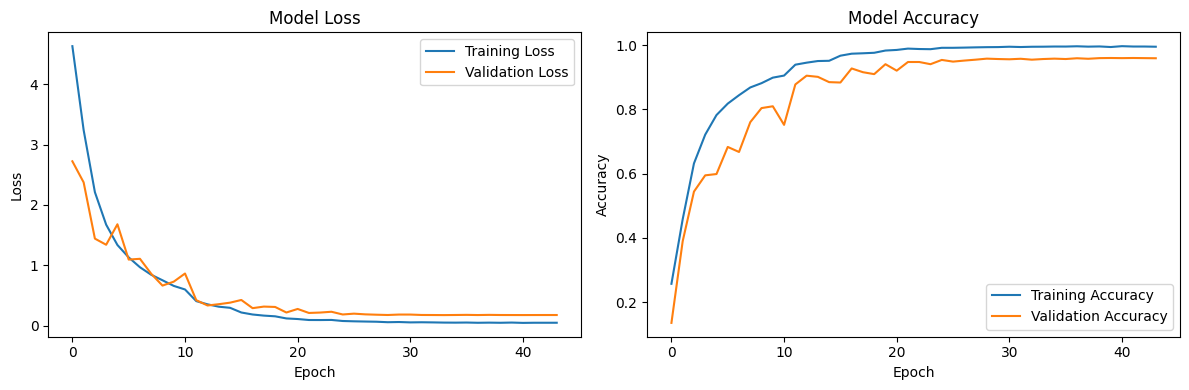

In [18]:
# Eğitim sonuçlarını görselleştirir
plt.figure(figsize=(12, 4))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 17. Test Veri Seti Üzerinde Model Değerlendirmesi

Modelin daha önce görmediği veriler üzerindeki gerçek performansını ölçülüyor.

### 🔹 Değerlendirme Parametreleri
- **Veri Seti**: `test_dataset` (eğitim sırasında kullanılmayan veriler)
- **Verbose**: 1 (ilerleme çubuğu gösterimi aktif)
- **Çıktı Formatı**: 4 ondalık basamak 

### 🔹 Ölçülen Metrikler
1. **Test Loss (Kayıp)**
   - Model tahminlerinin gerçek değerlerden sapma miktarı

2. **Test Accuracy (Doğruluk)**
   - Doğru tahmin edilen örneklerin yüzdesi
   - 0 ile 1 arasında bir değer (1 = %100 doğruluk)

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9546 - loss: 0.1604

Test accuracy: 0.9487
Test loss: 0.1705


# 18. Karmaşıklık Matrisi

Oluşturulan modelin her Simpson karakteri için tahmin performansını detaylı olarak analiz etmek için karmaşıklık matrisi (confusion matrix) oluşturuyor ve görselleştiriyoruz.

### 🔹 Veri Hazırlığı
- Test veri seti üzerinde batch'ler halinde tahminler yapılıyor
- Tahminler ve gerçek etiketler NumPy dizilerine dönüştürülüyor
- Softmax çıktıları en yüksek olasılıklı sınıfa dönüştürülüyor

### 🔹 Matrix'in Analiz Edilmesi
- Köşegen değerler: Doğru Sınıflandırmalar
- Köşegen dışı değerler: Yanlış Sınıflandırmalar
- Koyu renkli hücreler: Yüksek frekans
- Açık renkli hücreler: Düşük frekans

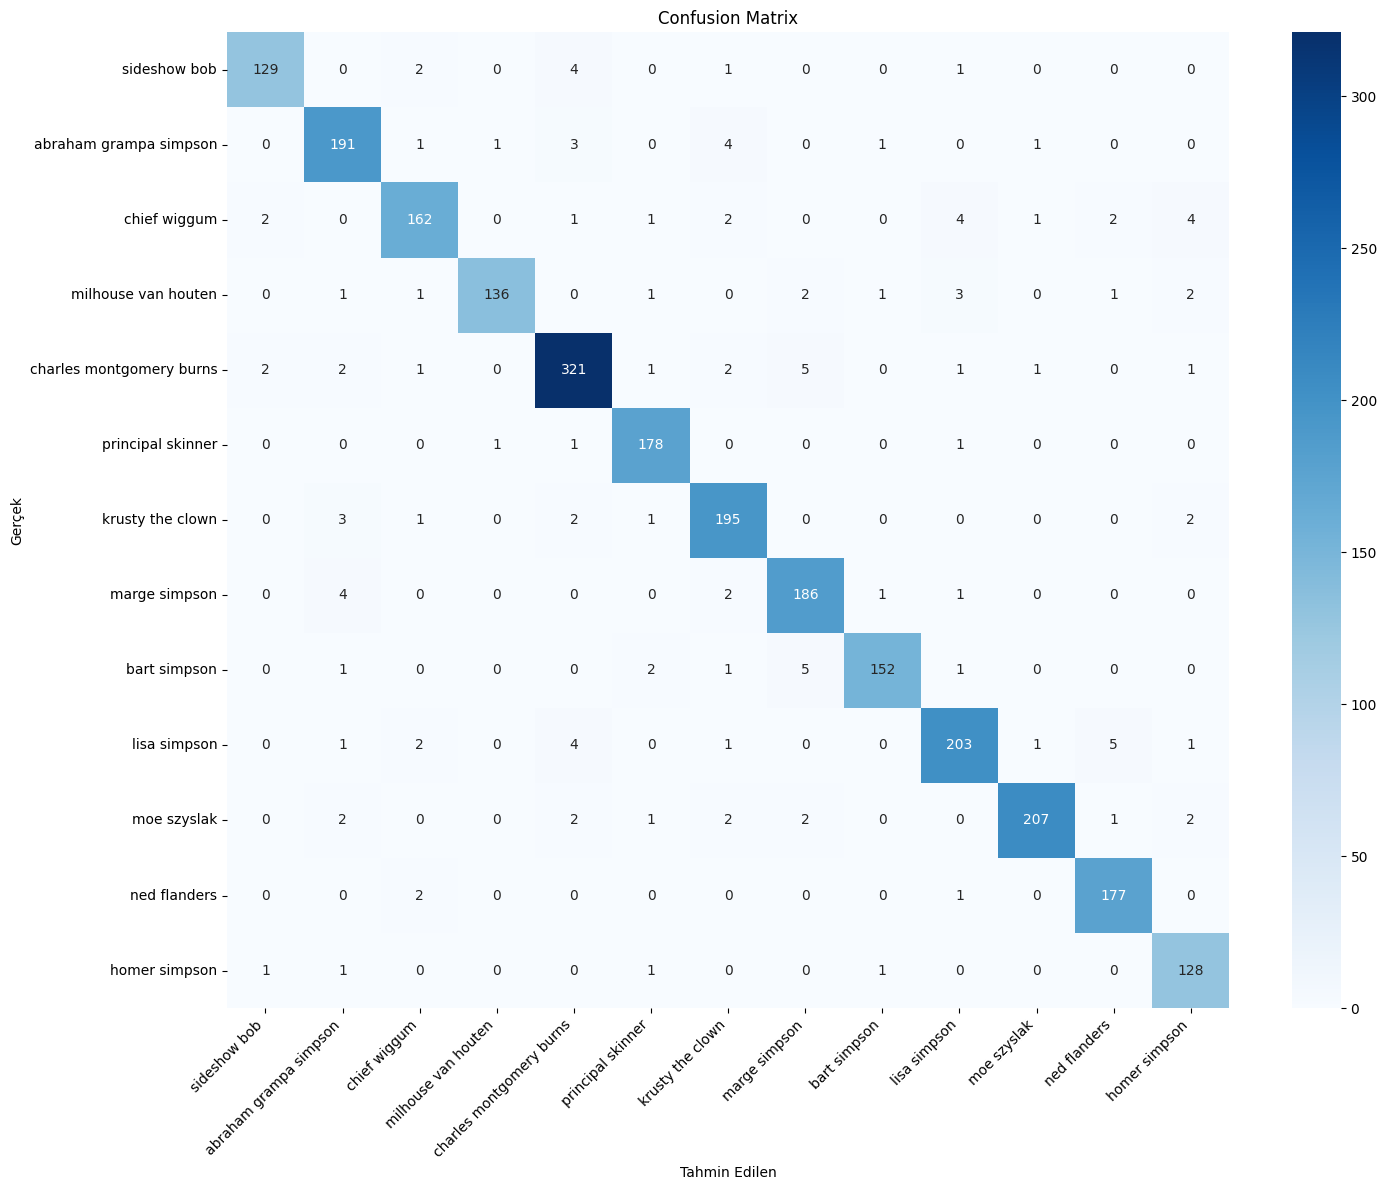

In [20]:
y_true = []
y_pred = []

for batch_images, batch_labels in test_dataset:
    batch_predictions = model.predict(batch_images, verbose=0)
    batch_pred_labels = np.argmax(batch_predictions, axis=1)

    y_true.extend(batch_labels.numpy())
    y_pred.extend(batch_pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[name.replace('_', ' ') for name in allowed_classes],
            yticklabels=[name.replace('_', ' ') for name in allowed_classes])

plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 19. Detaylı Performans Analizi

Oluşturulan modelin her Simpson karakteri için precision, recall ve f1-score metriklerini hesaplanıyor ve görselleştiriliyor.

In [21]:
print("\nDetaylı Performans Raporu:")
print(classification_report(
    y_true,
    y_pred,
    target_names=[name.replace('_', ' ') for name in allowed_classes],
    digits=4
))


Detaylı Performans Raporu:
                          precision    recall  f1-score   support

            sideshow bob     0.9627    0.9416    0.9520       137
  abraham grampa simpson     0.9272    0.9455    0.9363       202
            chief wiggum     0.9419    0.9050    0.9231       179
     milhouse van houten     0.9855    0.9189    0.9510       148
charles montgomery burns     0.9497    0.9525    0.9511       337
       principal skinner     0.9570    0.9834    0.9700       181
        krusty the clown     0.9286    0.9559    0.9420       204
           marge simpson     0.9300    0.9588    0.9442       194
            bart simpson     0.9744    0.9383    0.9560       162
            lisa simpson     0.9398    0.9312    0.9355       218
             moe szyslak     0.9810    0.9452    0.9628       219
            ned flanders     0.9516    0.9833    0.9672       180
           homer simpson     0.9143    0.9697    0.9412       132

                accuracy                      

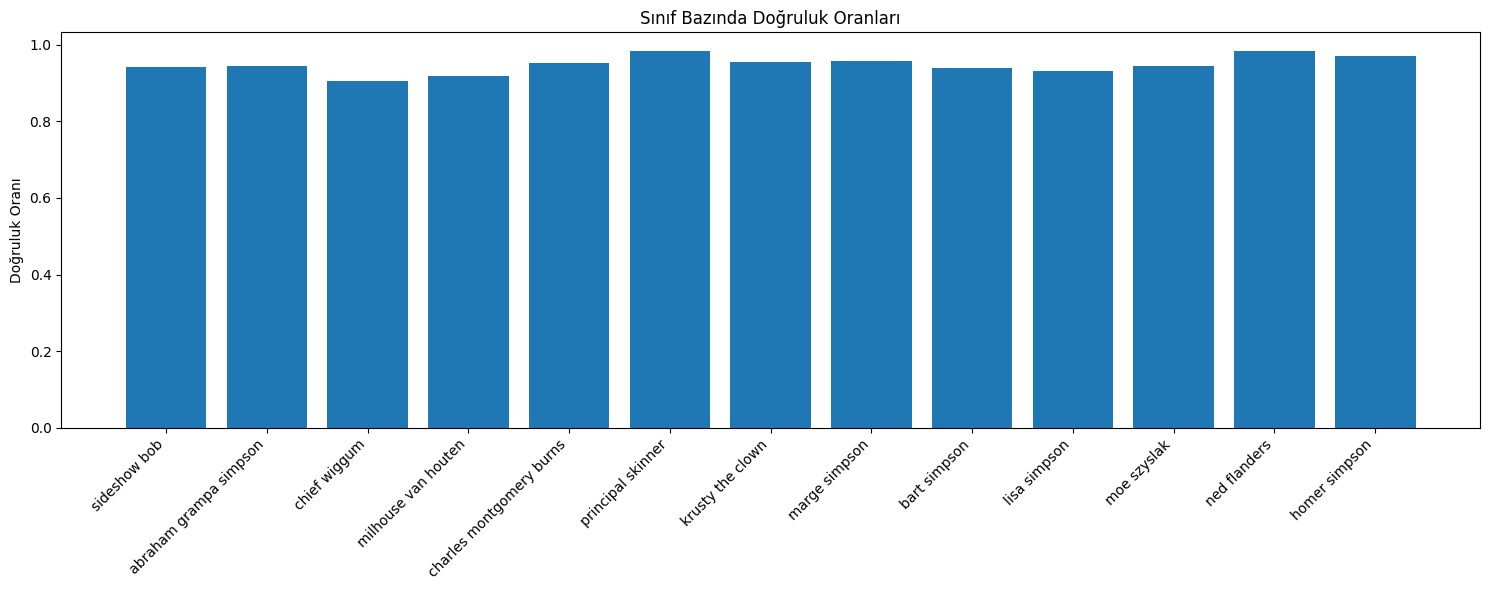

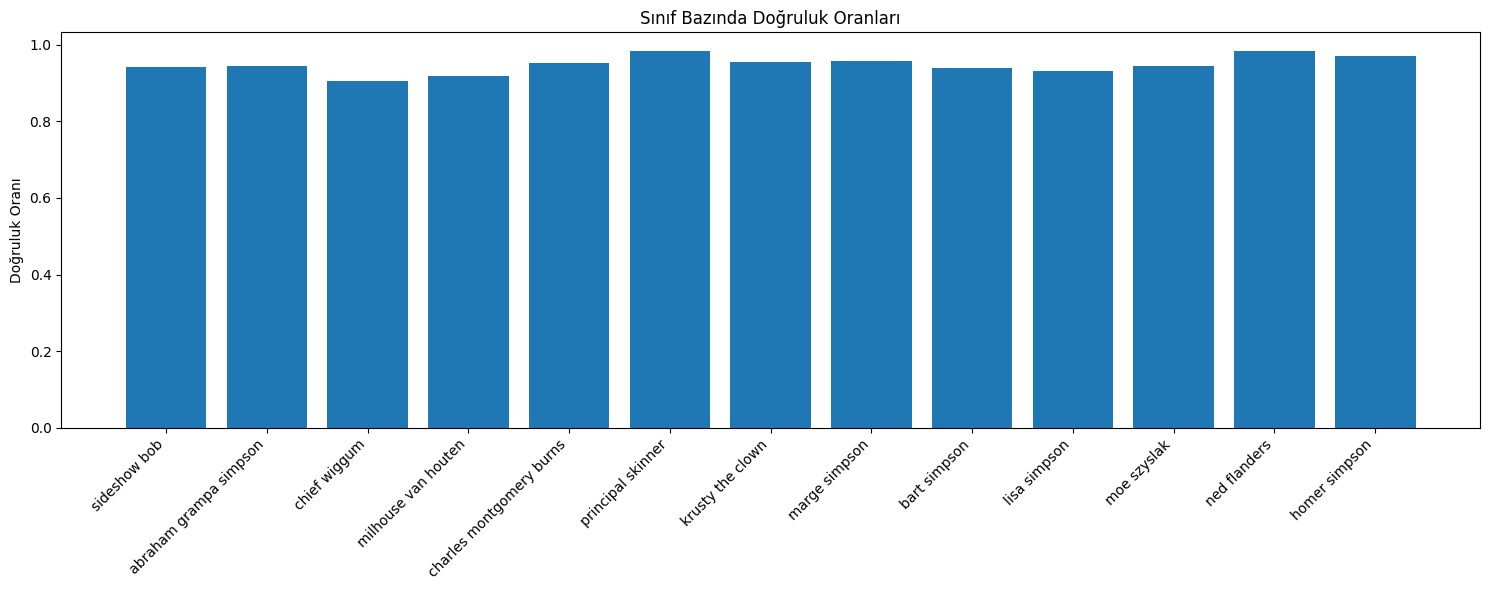

In [22]:
class_accuracies = {}
for i, class_name in enumerate(allowed_classes):
    class_mask = (y_true == i)
    class_accuracy = np.mean(y_pred[class_mask] == i)
    class_accuracies[class_name] = class_accuracyclass_accuracies = {}
for i, class_name in enumerate(allowed_classes):
    class_mask = (y_true == i)
    class_accuracy = np.mean(y_pred[class_mask] == i)
    class_accuracies[class_name] = class_accuracy

plt.figure(figsize=(15, 6))
plt.bar(
    [name.replace('_', ' ') for name in allowed_classes],
    [class_accuracies[name] for name in allowed_classes]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Doğruluk Oranı')
plt.title('Sınıf Bazında Doğruluk Oranları')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(
    [name.replace('_', ' ') for name in allowed_classes],
    [class_accuracies[name] for name in allowed_classes]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Doğruluk Oranı')
plt.title('Sınıf Bazında Doğruluk Oranları')
plt.tight_layout()
plt.show()

In [23]:
print("\nSınıf Bazında Doğruluk Oranları:")
for class_name in allowed_classes:
    print(f"{class_name.replace('_', ' ')}: {class_accuracies[class_name]:.4f}")


Sınıf Bazında Doğruluk Oranları:
sideshow bob: 0.9416
abraham grampa simpson: 0.9455
chief wiggum: 0.9050
milhouse van houten: 0.9189
charles montgomery burns: 0.9525
principal skinner: 0.9834
krusty the clown: 0.9559
marge simpson: 0.9588
bart simpson: 0.9383
lisa simpson: 0.9312
moe szyslak: 0.9452
ned flanders: 0.9833
homer simpson: 0.9697
